In [1]:
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import numpy as np

import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.frechet_mean import FrechetMean

import datetime
import pickle
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
anp.random.seed(42)


In [2]:
dim = 16
mu = 0.05
manifold = pymanopt.manifolds.Sphere(dim)
sphere = Hypersphere(dim=dim-1) 
fm_estimator = FrechetMean(sphere)

matrix = anp.random.normal(size=(dim, dim))
# matrix = 0.5 * (matrix + matrix.T)
matrix = matrix.T @ matrix


In [3]:
eigenvalues, eigenvectors = anp.linalg.eig(matrix)
print(f'Max Eig Value : {np.max(eigenvalues):.2f}')
print(eigenvalues)
dominant_eigenvector = eigenvectors[:, eigenvalues.argmax()]
# print(func_val(dominant_eigenvector,matrix))

Max Eig Value : 59.04
[5.90445795e+01 3.77773805e+01 2.99828493e+01 2.63210997e+01
 2.06347770e+01 1.64589192e+01 1.53632950e+01 1.27757982e+01
 8.47075203e+00 6.87088211e+00 5.87731198e+00 2.26286015e-02
 7.20488805e-02 1.41133755e+00 1.10422079e+00 7.40061408e-01]


In [4]:

def make_sym(x):
    return 0.5*(x+x.T)

def foo_euc(point,matrix):
    return -make_sym(point@matrix)+mu*np.sign(point)

def func_val(point,matrix):
    return -0.5*(point.T@matrix@point)+mu*np.sum(np.abs(point))

def foo_riem(manifold,point,matrix):
    grad_euc = foo_euc(point,matrix)
    return manifold.euclidean_to_riemannian_gradient(point, grad_euc)

def fo_stoc_riem(manifold,point,matrix):
    noise = 0.01*np.random.randn(*matrix.shape)
    noisy_matrix = matrix + make_sym(noise)
    grad_euc = foo_euc(point,noisy_matrix)
    return manifold.euclidean_to_riemannian_gradient(point, grad_euc)

def zoo_riem(manifold,point,matrix,dim,delta):
    
    vec = manifold.random_tangent_vector(point)
    vec = vec/np.linalg.norm(vec)
    p1 = manifold.exp(point,delta*vec)
    p2 = manifold.exp(point,-delta*vec)
    val1 = func_val(p1,matrix)
    val2 = func_val(p2,matrix)

    grad_est = 0.5*(dim/delta)*(val1-val2)*vec

    return grad_est 

def paral_trans(p1,p2,vec):
    return sphere.metric.parallel_transport(vec, p1, p2)

def clip_vec(vec,D):
    vec_norm = np.linalg.norm(vec)
    if vec_norm>D:
        vec = D*vec/vec_norm
    return vec

def get_sample():
    # noise = 0.001*np.random.randn(*matrix.shape)
    # data_sample = matrix + make_sym(noise)
    z= np.random.multivariate_normal(np.zeros(dim), matrix,1)
    data_sample = z.T@z
    return data_sample

def estimate_delta_norm(manifold,points):
    num_points = points.shape[0]
    grad = np.zeros(points.shape)
    for t in range(num_points):
        grad[t] = foo_riem(manifold,points[t,:],matrix)
    return np.mean(grad,axis=0)

def get_frechet_mean(points):
    fm_estimator.fit(points)
    return fm_estimator.estimate_


def estimate_delta_norm_pt(manifold,points):
    num_points = points.shape[0]
    fm_point = get_frechet_mean(points)

    grad = np.zeros(points.shape)
    for t,point in enumerate(points):
        gr = foo_riem(manifold,point,matrix)
        grad[t] = paral_trans( point ,fm_point  , gr  )
    
    return np.mean(grad,axis=0),fm_point

def avg_func_val(manifold,points):
    num_points = points.shape[0]
    vals = np.zeros(num_points)
    for t in range(num_points):
        vals[t] = func_val(points[t,:],matrix)
    return np.mean(vals)

In [5]:
def evaluate_results(all_points):
    delta_norm_euc = estimate_delta_norm(manifold,all_points)
    delta_norm_rie,fm_point = estimate_delta_norm_pt(manifold,all_points)
    val = avg_func_val(manifold,all_points)
    return delta_norm_euc,delta_norm_rie,val,fm_point

In [6]:
def save_results(config,results):

    data = {'config' : config, 'results' : results}
    date_str = datetime.datetime.now().strftime("%m_%d_%H_%M_%S")
    ora = config['oracle']
    trans=config['trans']
    D = config['D']
    lr = config['lr']
    pickle_file_name = f'results/{ora}_{trans}_{date_str}.pkl'
    with open(pickle_file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import os 
def read_file(result_folder,file):
    file_name = os.path.join(result_folder,file)
    file = open(file_name, 'rb')

    # dump information to that file
    data = pickle.load(file)

    # close the file
    file.close()

    return data['results'],data['config']

Simulation

In [8]:
def run_epoch_pt(point,num_iter,lr=0.05,D=0.05,oracle='first',trans='pt'):
    
    dim = point.shape[0]
    
    action = np.zeros(point.shape)
    avg_point= point / num_iter 
    points = np.zeros((num_iter,dim))

    if oracle =='first':
        def oracle_fun(point,sample):
            return foo_riem(manifold,point,sample)
    
    if oracle == 'zero':
        def oracle_fun(point,sample):
            delta = 0.5*D*num_iter
            return zoo_riem(manifold,point,sample,dim,delta)
 
    for t in range(num_iter):
    
        new_point = manifold.retraction(point,action)
        s=np.random.uniform()
        grad_point = manifold.retraction(point,s*action)
        data_sample = get_sample()
        
        # grad_rie = foo_riem(manifold,grad_point,data_sample)
        grad_rie = oracle_fun(grad_point,data_sample)

        grad_transport = sphere.metric.parallel_transport(grad_rie, grad_point, new_point)
        action_transport = sphere.metric.parallel_transport(action, point, new_point)
        action = action_transport - lr*grad_transport
        action = clip_vec(action,D)
        point = new_point
        points[t]=new_point
        avg_point += point / num_iter

    avg_point = avg_point / np.linalg.norm(avg_point)

    val = func_val(avg_point,matrix)
    grad_rie = foo_riem(manifold,avg_point,matrix)
    grad_norm = np.linalg.norm(grad_rie)
    action_norm = np.linalg.norm(action)

    
    # print(f'Iteration : {t} function value : {val:.2f}')
    # print(f'Iteration : {t} grad norm : {grad_norm:.2f}')
    # print(f'Iteration : {t} action norm : {action_norm:.2f}\n')

    return point,  avg_point , points

In [9]:
def run_epoch_vt(point,num_iter,lr=0.05,D=0.05,oracle='first'):
    dim = point.shape[0]
    action = np.zeros(point.shape)
    avg_point= point / num_iter 
    points = np.zeros((num_iter,dim))

    if oracle =='first':
        def oracle_fun(point,sample):
            return foo_riem(manifold,point,sample)
    
    if oracle == 'zero':
        def oracle_fun(point,sample):
            delta = 0.5*D*num_iter

            return zoo_riem(manifold,point,sample,dim,delta)

    for t in range(num_iter):
        new_point = manifold.retraction(point,action)
        s=np.random.uniform()
        grad_point = manifold.retraction(point,s*action)
        data_sample = get_sample()
        # grad_rie = foo_riem(manifold,grad_point,data_sample)
        grad_rie = oracle_fun(grad_point,data_sample)
        action = manifold.to_tangent_space(new_point, action-lr*grad_rie)
        action = clip_vec(action,D)
        point = new_point
        points[t]=new_point
        avg_point += point / num_iter

    avg_point = avg_point / np.linalg.norm(avg_point)

    val = func_val(avg_point,matrix)
    grad_rie = foo_riem(manifold,avg_point,matrix)
    grad_norm = np.linalg.norm(grad_rie)
    action_norm = np.linalg.norm(action)

    
    # print(f'Iteration : {t} function value : {val:.2f}')
    # print(f'Iteration : {t} grad norm : {grad_norm:.2f}')
    # print(f'Iteration : {t} action norm : {action_norm:.2f}\n')

    return point,  avg_point , points

In [10]:
def run_algo( num_it , num_ep , lr , D , point=None , oracle='first' , trans='pt'):
    
    if trans=='pt':
        def run_epoch(point,num_it,lr=lr,D=D,oracle=oracle):
            return run_epoch_pt(point,num_it,lr=lr,D=D,oracle=oracle)
    
    if trans=='vt':
        def run_epoch(point,num_it,lr=lr,D=D,oracle=oracle):
            return run_epoch_vt(point , num_it , lr=lr , D=D , oracle=oracle)
    
    avg_grad_norm_euc = np.zeros(num_ep)
    avg_grad_norm_pt = np.zeros(num_ep)
    avg_vals = np.zeros(num_ep)  
    fm_points = np.zeros((num_ep,point.shape[0]))
    

    for i in range(num_ep):
        point,avg_point,all_points = run_epoch(point , num_it ,lr=lr , D=D , oracle=oracle)
        delta_norm_euc,delta_norm_rie,val,fm_point = evaluate_results(all_points)
        avg_grad_norm_euc[i] = np.linalg.norm(delta_norm_euc)
        avg_grad_norm_pt[i] = np.linalg.norm(delta_norm_rie)
        avg_vals[i] = val
        fm_points[i,:]=fm_point

        print(f'Epoch : {i}: delta norm {avg_grad_norm_pt[i]:.4f}')
        print(f'Epoch : {i}: avg value {avg_vals[i]:.4f}\n')
    
    return avg_grad_norm_euc,avg_grad_norm_pt,avg_vals,fm_points 

In [11]:
def run_sim(num_it,num_ep,init_point):
    
    # D_list = [1e-3,1e-4,5e-5]
    # lr_list =[1e-6,1e-7,5e-7]

    D_list = [3e-4]
    lr_list =[1e-6]
    

    for D,lr in zip(D_list,lr_list):
        for ora in ['first','zero']:
            for tra in ['pt','vt']:
                avg_grad_norm_euc,avg_grad_norm_pt,avg_vals,fm_points = run_algo( num_it , num_ep , lr , D , point=init_point , oracle=ora , trans=tra)
                config={'num_iter':num_it,'num_ep':num_ep,'D':D,'lr':lr,'init_point':init_point,'mu':mu,'dim':dim,'oracle':ora,'trans':tra}
                results = {'grad_norm_euc':avg_grad_norm_euc, 'avg_grad_norm_pt':avg_grad_norm_pt,'avg_vals':avg_vals}
                save_results(config,results)

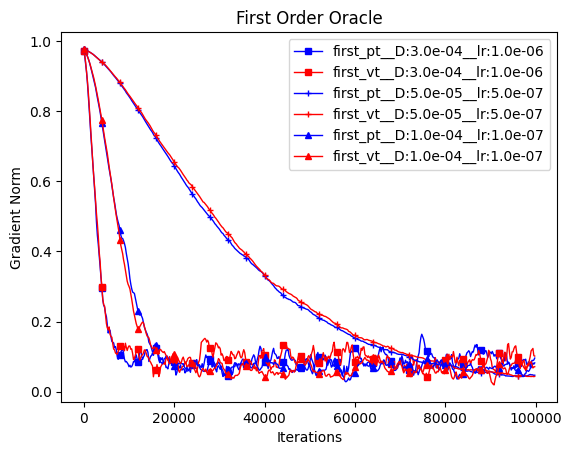

In [ ]:
# result_folder = 'results/2' # D=1e-4
# result_folder = 'results/3' # D=1e-4 ,5e-5
result_folder = 'results' # D=1e-4

files = [file for file in os.listdir(result_folder) if file.endswith('.pkl') and file.startswith('first')]

coef=0.05

ptk=-1
vtk=-1
style = ['b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*','b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*']
markers=['s','+','^','o','v','2']
plt.figure()
for file in files:
    results,config = read_file(result_folder ,file)
    D=config['D']
    if D>4e-4:
        continue

    if file.startswith('first_pt'):
        ptk+=1
        st = 'b-'+markers[ptk]
        
    if file.startswith('first_vt'):
        vtk+=1
        st = 'r-'+markers[vtk]
    
    avg_grad_norm_pt = coef*results['avg_grad_norm_pt']
    ora = config['oracle']
    tra = config['trans']

    num_iter = config['num_iter']
    num_epoch = config['num_ep']
    iterations = np.arange(0,num_iter*num_epoch,num_iter)
    # D=config['D']
    lr = config['lr']
    label = f'{ora}_{tra}__D:{D:.1e}__lr:{lr:.1e}'
    plt.plot(iterations,avg_grad_norm_pt,st,linewidth=1, markersize=4, markevery=20,label = label)

plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.title('First Order Oracle')
plt.legend()

plt.savefig('figures/f13_Dim16_first2.pdf', format="pdf", bbox_inches="tight")
plt.show()
# plt.savefig('figures/f3_D1e4.pdf', format="pdf", bbox_inches="tight")

    

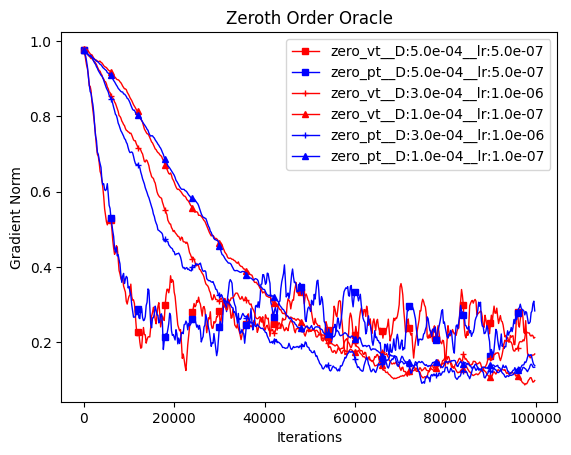

In [ ]:
# result_folder = 'results/2' # D=1e-4
result_folder = 'results/3' # D=1e-4 ,5e-5
result_folder = 'results' # D=1e-4

coef=0.05

files = [file for file in os.listdir(result_folder) if file.endswith('.pkl') and file.startswith('zero')]

ptk=-1
vtk=-1
style = ['b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*','b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*']
markers=['s','+','^','o','v','2']
plt.figure()
for file in files:
    results,config = read_file(result_folder ,file)
    D=config['D']

    if D<8e-5:
        continue
    if D>9e-4:
        continue
    
    if file.startswith('zero_pt'):
        ptk+=1
        st = 'b-'+markers[ptk]
        
    if file.startswith('zero_vt'):
        vtk+=1
        st = 'r-'+markers[vtk]


    avg_grad_norm_pt = coef*results['avg_grad_norm_pt']
    ora = config['oracle']
    tra = config['trans']

    num_iter = config['num_iter']
    num_epoch = config['num_ep']
    iterations = np.arange(0,num_iter*num_epoch,num_iter)
    # D=config['D']
    lr = config['lr']
    label = f'{ora}_{tra}__D:{D:.1e}__lr:{lr:.1e}'
    plt.plot(iterations,avg_grad_norm_pt,st,linewidth=1, markersize=4, markevery=30,label = label)

plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.title('Zeroth Order Oracle')
plt.legend()

plt.savefig('figures/f13_Dim16_zero.pdf', format="pdf", bbox_inches="tight")

plt.show()
    

projection   D : 5.0e-04 $\eta$ : 5.0e-07
parallel     D : 5.0e-04 $\eta$ : 5.0e-07
projection   D : 3.0e-04 $\eta$ : 1.0e-06
projection   D : 1.0e-04 $\eta$ : 1.0e-07
parallel     D : 3.0e-04 $\eta$ : 1.0e-06
parallel     D : 1.0e-04 $\eta$ : 1.0e-07


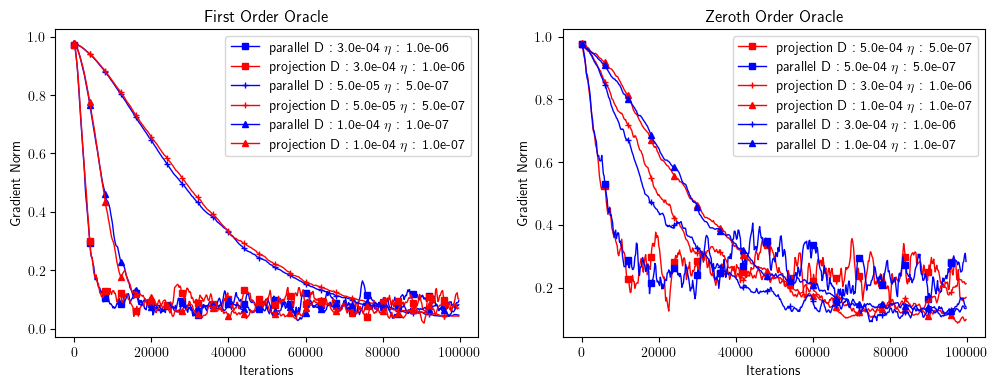

<Figure size 640x480 with 0 Axes>

In [ ]:
# result_folder = 'results/2' # D=1e-4
# result_folder = 'results/3' # D=1e-4 ,5e-5


fig1, ax1 = plt.subplots(1,2,figsize=(12,4))
result_folder = 'results' # D=1e-4
files = [file for file in os.listdir(result_folder) if file.endswith('.pkl') and file.startswith('first')]
coef=0.05

ptk=-1
vtk=-1
style = ['b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*','b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*']
markers=['s','+','^','o','v','2']
plt.figure()
for file in files:
    results,config = read_file(result_folder ,file)
    D=config['D']
    if D>4e-4:
        continue

    if file.startswith('first_pt'):
        ptk+=1
        st = 'b-'+markers[ptk]
        tr_label = 'parallel \t'
        
    if file.startswith('first_vt'):
        vtk+=1
        st = 'r-'+markers[vtk]
        tr_label = 'projection'
    
    avg_grad_norm_pt = coef*results['avg_grad_norm_pt']
    ora = config['oracle']
    tra = config['trans']

    num_iter = config['num_iter']
    num_epoch = config['num_ep']
    iterations = np.arange(0,num_iter*num_epoch,num_iter)
    # D=config['D']
    lr = config['lr']
    label = f'{tr_label} D : {D:.1e} $\eta$ : {lr:.1e}'
    ax1[0].plot(iterations,avg_grad_norm_pt,st,linewidth=1, markersize=4, markevery=20,label = label)

ax1[0].set_xlabel('Iterations')
ax1[0].set_ylabel('Gradient Norm')
ax1[0].set_title('First Order Oracle')
ax1[0].legend()

files = [file for file in os.listdir(result_folder) if file.endswith('.pkl') and file.startswith('zero')]

ptk=-1
vtk=-1
style = ['b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*','b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*']
markers=['s','+','^','o','v','2']
# plt.figure()
for file in files:
    results,config = read_file(result_folder ,file)
    D=config['D']

    if D<8e-5:
        continue
    if D>9e-4:
        continue
    
    if file.startswith('zero_pt'):
        ptk+=1
        st = 'b-'+markers[ptk]
        tr_label='parallel '
        
    if file.startswith('zero_vt'):
        vtk+=1
        st = 'r-'+markers[vtk]
        tr_label='projection'


    avg_grad_norm_pt = coef*results['avg_grad_norm_pt']
    ora = config['oracle']
    tra = config['trans']

    num_iter = config['num_iter']
    num_epoch = config['num_ep']
    iterations = np.arange(0,num_iter*num_epoch,num_iter)
    # D=config['D']
    lr = config['lr']
    label = f'{tr_label.ljust(12)} D : {D:.1e} $\eta$ : {lr:.1e}'
    # label = label.replace('\t','   ')
    print(label)
    ax1[1].plot(iterations,avg_grad_norm_pt,st,linewidth=1, markersize=4, markevery=30,label = label)

ax1[1].set_xlabel('Iterations')
ax1[1].set_ylabel('Gradient Norm')
ax1[1].set_title('Zeroth Order Oracle')
ax1[1].legend()

# plt.savefig('figures/f13_Dim16_combined.pdf', format="pdf", bbox_inches="tight")


# plt.savefig('figures/f13_Dim16_combined.pdf' , bbox_inches="tight" )

plt.show()
    


# plt.savefig('figures/f13_Dim16_first2.pdf', format="pdf", bbox_inches="tight")
# plt.show()
# plt.savefig('figures/f3_D1e4.pdf', format="pdf", bbox_inches="tight")

    

In [ ]:
fig1.savefig('figures/f13_Dim16_combined.pdf' ,format='pdf', bbox_inches="tight" )